In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

### Constants

In [2]:
F = 96485 # C / mol
ne_H2 = 2 # mol e / mol H
m_H2 = 2 # g/mol
g_to_kg = 1000
G0 = 237000 # J / mol
H0 = 285000 # J / mol
S0 = 163 # J / mol-K
V_to_eff = 26.8 # conversion factor for hydrogen

In [3]:
### Model assumptions = = = =
## Comment out the variable functions
# System function
replace_rate = 7

#MINCELLV = 1.65 #V
MINCELLJ = 1 #A/cm^2
#CELL_COST = 0.1 #$/cm^2

#Operating
ELECTRIC = 0.01# $/kWh
CAPACITY = 0.4

#Durability
voltage_drift = 1E-6 # V/h
stack_replacement = 0.15 # fraction

# Finances
IRR = 0.10 # fractional rate
INFLATION = 0.019 # fractional rate


### Cell and Stack Design

In [4]:
## Balance of plant
# Reference: https://www.nrel.gov/hydrogen/assets/docs/current-central-pem-electrolysis-v3-2018.xlsm

## Stack model
hydrogen_prod = 50000/24 #kg/h ... 50 tonnes per day divided by 24 hours
max_year = 20

# def bop_model(min_cell_voltage=MINCELLV,cell_J=MINCELLJ,cell_cost=0.2):
#     ## Cell model defaults
#     #====Secondary input====
#     bop_electrical = 5 #kWh/kg
#     min_power = min_cell_voltage * cell_J * total_cell_area / 1000 # kW
#     #====Model input
#     stack_cost = total_cell_area * cell_cost
#     #====
#     power_specific_cost = stack_cost / min_power
    
# #     print()
# #     print("Cell efficiency {0:.1f} kWh/kg".format(min_cell_voltage*V_to_eff))
# #     print("System efficiency {0:.1f} kWh/kg".format(min_cell_voltage*V_to_eff+bop_electrical))
# #     print("Power specific cost ${0:.2f}/kW".format(power_specific_cost))
    
#     return stack_cost, total_cell_area

### Cash flow set up

In [5]:
def system_model(stack_cost, min_cell_voltage, cell_J=MINCELLJ, replace_rate=replace_rate):
    #Capital costs
    #====Secondary input====
    bop_electrical = 5 #kWh/kg
    elec_bop_cost = 82 #$/kW
    mech_bop_cost = 76 #$/(kg/day)
    
    cell_prod = cell_J / (ne_H2*F) * (3600 / g_to_kg * m_H2) #kg/h/cm^2
    total_cell_area = hydrogen_prod/cell_prod # cm^2

    maximum_power = (min_cell_voltage + voltage_drift*8760*stack_replacement) * cell_J * total_cell_area / 1000 # kW
    #====Model inputs
    system_cost = stack_cost*maximum_power + elec_bop_cost*maximum_power + mech_bop_cost*hydrogen_prod*24
    #====
#     print()
#     print("Total system cost is ${0:.2f} million".format(system_cost/1e6))
#     print("Stack:  ${0:.2f} million".format(stack_cost*maximum_power/1e6))
#     print("Electrical: ${0:.2f} million".format(elec_bop_cost*maximum_power/1e6))
#     print("Mechanical: ${0:.2f} million".format(mech_bop_cost*hydrogen_prod*24/1e6))
    
#     #Installation costs of 12%
#     system_cost = 1.12*system_cost
    
    return system_cost

### Calculate LCOH

In [6]:
def NPV_calc(h2_price, system_cost, stack_cost, min_cell_voltage, show_results=False):
    
   #Scheduled cash flow
    CashFlow = pd.DataFrame({'Years':[],'Stack Life':[],'Inflation Year':[],
                            'Stack Eff':[], 'Hydrogen Sales':[],'Replacement Costs':[],'Operating Costs':[],
                            'Net Cash Flow':[],'Discounted Flow':[]})

    ## Initialize variables
    year = [1]
    stacklife = [0]
    inflationyear = [1]
    stackeff = [0]
    hydrogensales = [0]
    replacement_costs = [0]
    operating_costs = [0]
    net_cash = [-system_cost]
    discounted_cash = [net_cash[-1]/(1+IRR)**year[-1]]

    for x in range(2,max_year+2):
        year.append(x)
        inflationyear.append((1+INFLATION)**x)

        #Hydrogen sales
        hydrogensales.append(h2_price*hydrogen_prod*8760*CAPACITY) # [$/kg] * [kg/h] * [h/year] * percent
        hydrogensales[-1] = hydrogensales[-1]*inflationyear[-1]

        #Stacklife counting
        if year[-1] == (max_year+1): # Don't replace stack in the last year of life
            stacklife.append(stacklife[-1]+1)           
        elif stacklife[-1] < replace_rate:
            stacklife.append(stacklife[-1]+1)
        else:
            stacklife.append(1)

        #Maintenance cost are 0.005% system cost per year + stack replacement
        replacement_costs.append(stack_replacement*system_cost*(stacklife[-1]==replace_rate) + 0.005*system_cost)
        replacement_costs[-1] = replacement_costs[-1]*inflationyear[-1]

        #Stack efficiency is the average of the beginning and end of year efficiency
        try:
            stackeff.append(V_to_eff*(min_cell_voltage + voltage_drift*8760*CAPACITY*(stacklife[-1]+stacklife[-1]-1) / 2) )
        except: 
            stackeff.append(V_to_eff*(MINCELLV + voltage_drift*8760*CAPACITY*(stacklife[-1]+stacklife[-1]-1) / 2) )
            
        #Operating costs are assumed to be dominated by electricity prices
        operating_costs.append(ELECTRIC*stackeff[-1]*hydrogen_prod*8760*CAPACITY) # [$/kWh] * [kWh/kg] * [kg/h] * [h/year] * percent
        operating_costs[-1] = operating_costs[-1]*inflationyear[-1]

        #Net cash flow = Sales - replacement - operating costs
        net_cash.append(hydrogensales[-1] - operating_costs[-1] - replacement_costs[-1])

        #Discounted cash flow = net cash flow / (1+IRR)^year
        discounted_cash.append(net_cash[-1]/(1+IRR)**year[-1])

    CashFlow['Years'] = year
    CashFlow['Stack Life'] = stacklife
    CashFlow['Inflation Year'] = inflationyear
    CashFlow['Stack Eff'] = stackeff
    CashFlow['Hydrogen Sales'] = hydrogensales
    CashFlow['Replacement Costs'] = replacement_costs
    CashFlow['Operating Costs'] = operating_costs
    CashFlow['Net Cash Flow'] = net_cash
    CashFlow['Discounted Flow'] = discounted_cash
    
    if show_results:
        return CashFlow
    else:
        return sum(CashFlow['Discounted Flow'])


In [7]:
def LCOH(stack_cost,cell_V):

    # System function
    system_cost = system_model(stack_cost=stack_cost, min_cell_voltage=cell_V)

    low_price = 0.10
    high_price = 20
    low_val = NPV_calc(low_price,  min_cell_voltage=cell_V,system_cost=system_cost, stack_cost=stack_cost)
    high_val = NPV_calc(high_price,  min_cell_voltage=cell_V,system_cost=system_cost, stack_cost=stack_cost);
    
    slope = (high_price - low_price)/(high_val - low_val)
    
#     print()
#     print(" = = = = = = = = = ")
#     print("Electricty price = ${0:0.2f}/kWh".format(ELECTRIC))
#     print("Capacity factor = {0:0.2f}/kWh".format(CAPACITY))
#     print("Stack Voltage = ${0:0.2f}/kWh".format(min_cell_voltage))
#     print("Levelized cost of hydrogen ($/kg) is... ")
    
    return high_price - high_val*slope

### Iterate across LCOH vs model assumptions

Iteratively set up model + build NPV function before running LCOH function to calculate LCOH

In [8]:
## Set up a mesh grid for desired variables
Es = np.linspace(1,2.5,20)
Stacks = np.logspace(1,3.7,20)
XX,YY = np.meshgrid(Es,Stacks) # syntax is columns, rows
rs, cs = np.shape(XX)
Z = np.zeros((rs,cs))

for row in range(0,len(Stacks)):
    for col in range(0,len(Es)):
            cell_V = XX[row,col]
            stack_cost = YY[row,col]
            Z[row,col] = LCOH(stack_cost=stack_cost, cell_V=cell_V)

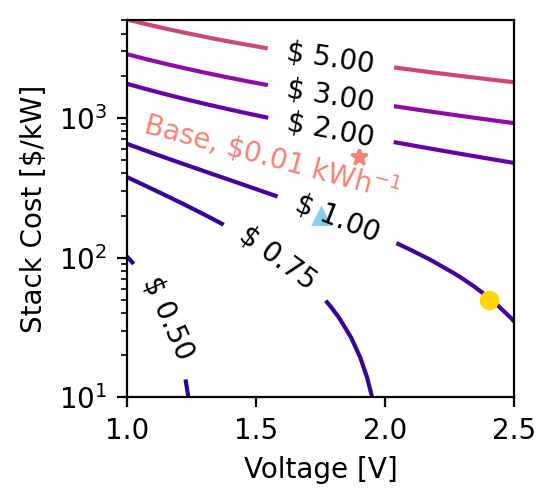

In [23]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
manual_lines = [0.5, 0.75, 1, 2, 3, 5]

ax.plot(1.9, 526,'*',color='salmon') # Base case
ax.text(1.05,255,'Base, \$0.01 kWh$^{-1}$',color='salmon',rotation=-15) # Base case
ax.plot(1.75, 200,'^',color='skyblue') # Expensive efficient
ax.plot(2.4, 50,'o',color='gold') # Cheap inefficient

CS = ax.contour(XX, YY, Z, manual_lines, cmap='plasma', vmin=0, vmax=10)
ax.set_yscale('log')
ax.set_xlabel('Voltage [V]')
ax.set_ylabel('Stack Cost [\$/kW]')
ax.clabel(CS, inline=True, colors='k', fmt='$ %1.2f')
plt.gcf().set_dpi(200)